In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
        print(dirname)

/kaggle/input
/kaggle/input/siim-isic-melanoma-classification
/kaggle/input/siim-isic-melanoma-classification/train
/kaggle/input/siim-isic-melanoma-classification/test
/kaggle/input/siim-isic-melanoma-classification/jpeg
/kaggle/input/siim-isic-melanoma-classification/jpeg/train
/kaggle/input/siim-isic-melanoma-classification/jpeg/test
/kaggle/input/siim-isic-melanoma-classification/tfrecords


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

# Exploratory Data Analysis

When we’re getting started with a machine learning (ML) project, one critical principle to keep in mind is that data is everything. It is often said that if ML is the rocket engine, then the fuel is the (high-quality) data fed to ML algorithms. However, deriving truth and insight from a pile of data can be a complicated and error-prone job. To have a solid start for our ML project, it always helps to analyze the data up front. 

During EDA, it’s important that we get a deep understanding of: 

* The properties of the data, such as schema and statistical properties;
* The quality of the data, like missing values and inconsistent data types;
* The predictive power of the data, such as correlation of features against target.

## dicom format : 

A DICOM file is an image saved in the Digital Imaging and Communications in Medicine (DICOM) format. It contains an image from a medical scan, such as an ultrasound or MRI. **

In [3]:
train = pd.DataFrame(pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/train.csv"))
test = pd.DataFrame(pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/test.csv"))

In [4]:
train.shape, test.shape

((33126, 8), (10982, 5))

So, there are around 33k training images and about 10k testing images

In [5]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


Every patient has an ID, however it might be that one patient may have multiple wound records. Let's fish that out.

In [8]:
len(train["patient_id"].unique())

2056

In [9]:
train["target"].value_counts()

0    32542
1      584
Name: target, dtype: int64

# Distribution Observation

Malignant VS Benign cases - OVERALL

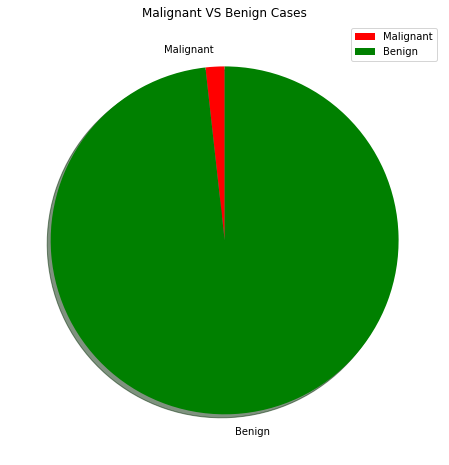

In [10]:
malignant = len(train[train["target"] == 1])
benign = len(train[train["target"] == 0])

labels = ["Malignant", "Benign"] 
size = [malignant, benign]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, shadow = True, startangle = 90, colors = ["r", "g"])
plt.title("Malignant VS Benign Cases")
plt.legend()

Male VS Female Count

Number of males =  17080
Number of females =  15981


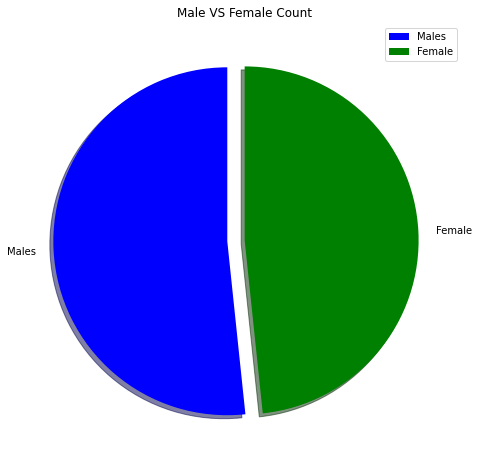

In [11]:
males = len(train[train["sex"] == "male"])
females  = len(train[train["sex"] == "female"])

labels = ["Males", "Female"] 
size = [males, females]
explode = [0.1, 0.0]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["b", "g"])
plt.title("Male VS Female Count")
plt.legend()
print("Number of males = ", males)
print("Number of females = ", females)

Malignant male cases VS female cases

Malignant Male Cases =  364
Malignant Female Cases =  220


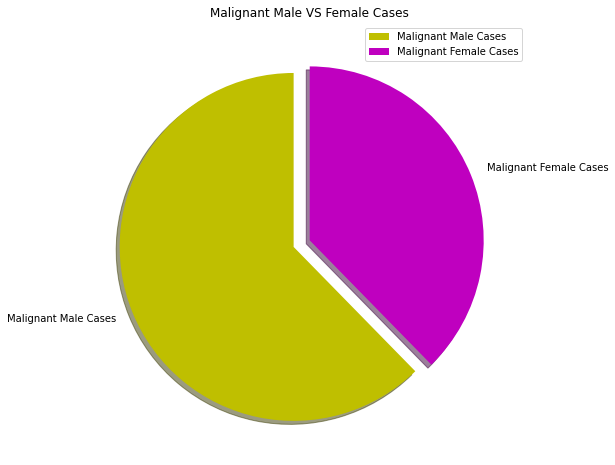

In [12]:
malignant  = train[train["target"] == 1]

malignant_males = len(malignant[malignant["sex"] == "male"])
malignant_females  = len(malignant[malignant["sex"] == "female"])

labels = ["Malignant Male Cases", "Malignant Female Cases"] 
size = [malignant_males, malignant_females]
explode = [0.1, 0.0]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["y", "m"])
plt.title("Malignant Male VS Female Cases")
plt.legend()
print("Malignant Male Cases = ", malignant_males)
print("Malignant Female Cases = ", malignant_females)

Benign male cases vs female cases

Benign Male Cases =  16716
Benign Female Cases =  15761


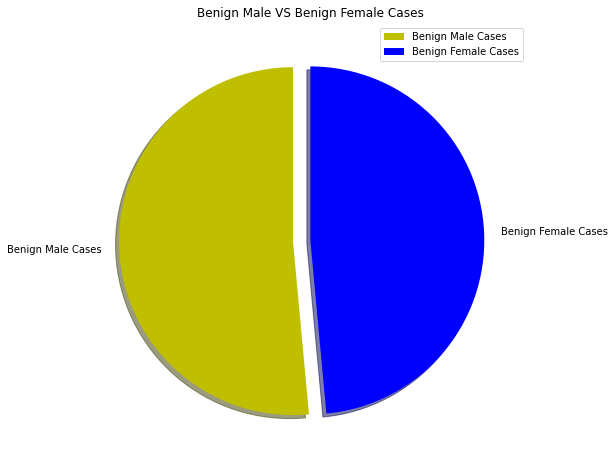

In [13]:
benign  = train[train["target"] == 0]

benign_males = len(benign[benign["sex"] == "male"])
benign_females  = len(benign[benign["sex"] == "female"]) 

labels = ["Benign Male Cases", "Benign Female Cases"] 
size = [benign_males, benign_females]
explode = [0.1, 0.0]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["y", "b"])
plt.title("Benign Male VS Benign Female Cases")
plt.legend()
print("Benign Male Cases = ", benign_males)
print("Benign Female Cases = ", benign_females)

In [14]:
print(train["anatom_site_general_challenge"].unique())
print(train["anatom_site_general_challenge"].value_counts())

['head/neck' 'upper extremity' 'lower extremity' 'torso' nan 'palms/soles'
 'oral/genital']
torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64


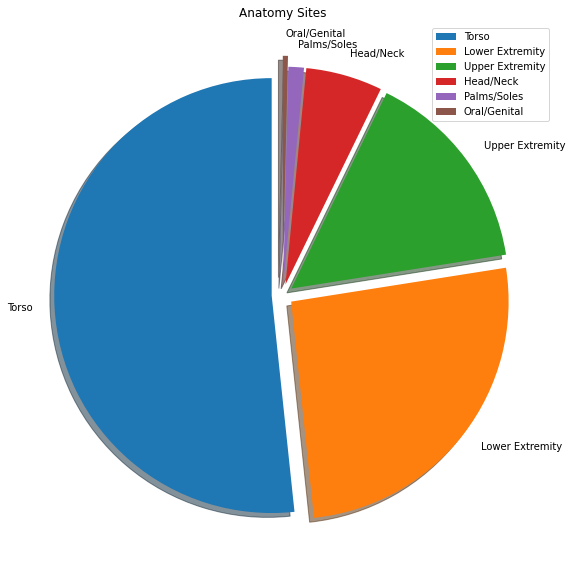

In [15]:
torso = len(train[train["anatom_site_general_challenge"] == "torso"])
lower_extremity = len(train[train["anatom_site_general_challenge"] == "lower extremity"])
upper_extremity = len(train[train["anatom_site_general_challenge"] == "upper extremity"])
head_neck = len(train[train["anatom_site_general_challenge"] == "head/neck"])
palms_soles = len(train[train["anatom_site_general_challenge"] == "palms/soles"])
oral_genital = len(train[train["anatom_site_general_challenge"] == "oral/genital"])

labels = ["Torso", "Lower Extremity", "Upper Extremity", "Head/Neck", "Palms/Soles", "Oral/Genital"] 
size = [torso,lower_extremity, upper_extremity, head_neck, palms_soles, oral_genital]
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.1]
plt.figure(figsize = (12, 10))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90)
plt.title("Anatomy Sites")
plt.legend()

It seems like majority of the cases are observed at the torso, and after that the extremities of the body (upper/lower). 

Text(0.5, 1.0, 'Probabilistic Age Distribution')

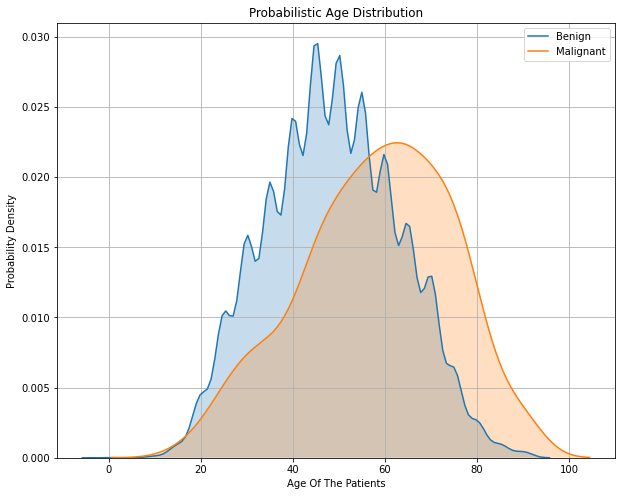

In [16]:
ages_benign = train.loc[train["target"] == 0, "age_approx"]
ages_malignant = train.loc[train["target"] == 1 , "age_approx"]

plt.figure(figsize = (10, 8))
sns.kdeplot(ages_benign, label = "Benign", shade = True, legend = True, cbar = True)
sns.kdeplot(ages_malignant, label = "Malignant", shade = True, legend = True, cbar = True)
plt.grid(True)
plt.xlabel("Age Of The Patients")
plt.ylabel("Probability Density")
plt.grid(which = "minor", axis = "both")
plt.title("Probabilistic Age Distribution")

In [17]:
image_names = train["image_name"].values
image_names = image_names + ".jpg"
image_names

array(['ISIC_2637011.jpg', 'ISIC_0015719.jpg', 'ISIC_0052212.jpg', ...,
       'ISIC_9999515.jpg', 'ISIC_9999666.jpg', 'ISIC_9999806.jpg'],
      dtype=object)

We generate 4 random samples from the training data set. These 4 samples are taken from the aforementioned array of names.

In [18]:
random_images = [np.random.choice(image_names) for i in range(4)]
random_images 

['ISIC_5832440.jpg',
 'ISIC_8730957.jpg',
 'ISIC_2203239.jpg',
 'ISIC_1464309.jpg']

# Sample Images

Earlier we extracted paths of all directories. So, we will access these images from there.

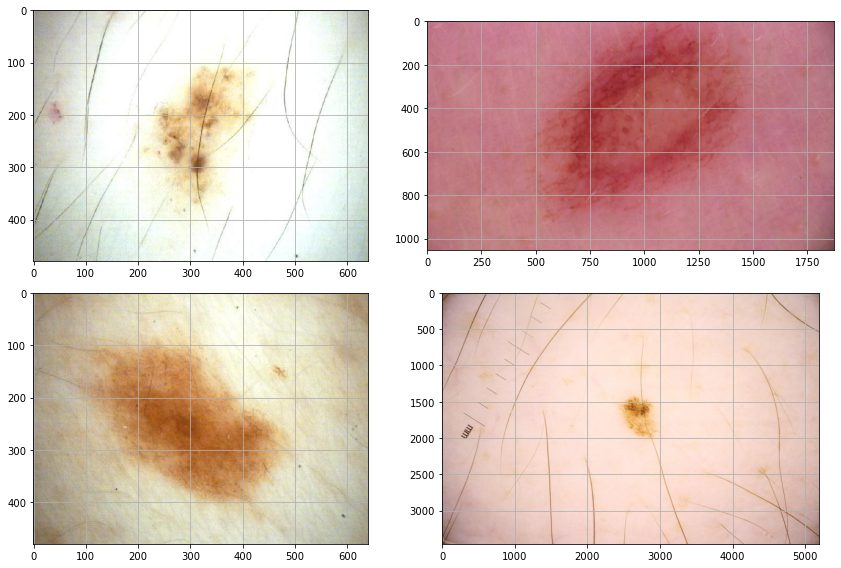

In [19]:
train_dir = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

plt.figure(figsize = (12, 8))
for i in range(4) : 
    plt.subplot(2, 2, i + 1) 
    image = cv2.imread(os.path.join(train_dir, random_images[i]))
    # cv2 reads images in BGR format. Hence we convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap = "gray")
    plt.grid(True)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

# Analysis of color distribution

Benign Cases : 

Since we have a lot of images here, hence we randomly sample only a thousand of them.

In [20]:
# Benign Cases
benign = train[train["target"] == 0] 
image_names = benign["image_name"].values
image_names = image_names + ".jpg"
benign_image_list = [np.random.choice(image_names) for i in tqdm(range(1000))]

red = []
green = [] 
blue = []

for image_name in tqdm(benign_image_list) : 
    image = cv2.imread(os.path.join(train_dir, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mean_red = np.mean(image[:,:,0])
    mean_green = np.mean(image[:,:,1])
    mean_blue = np.mean(image[:,:,2])
    
    red.append(mean_red)
    green.append(mean_green)
    blue.append(mean_blue)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


### Skewness in EDA : 

Skewness is the measure of symmetry or asymmetry of a data distribution.
A distribution or data set is said to be symmetric if it looks same to the left and right point of the center. 

#### `Types of Skewness` : 

Skewness is generally classified into 2 broad categories-
* Right skewness or Positive skewness
* Left skewness or Negative skewness

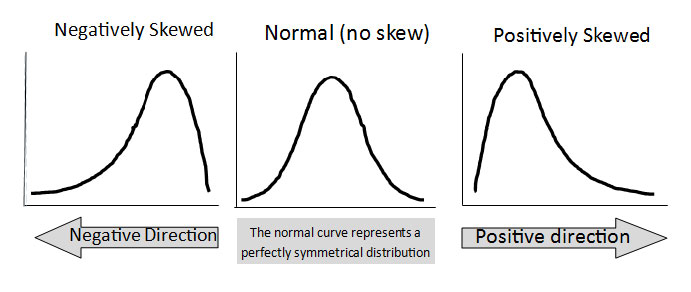

### Kurtosis : 

Kurtosis is the characteristics of being flat or peaked. It is a measure whether data is heavy- tailed or light-tailed in a normal distribution

A large kurtosis value often mean that the tails of the distributions are getting toward more extreme values than the tails of normal distributions. This may lead to a length of 6 or 7 standard deviation from the mean. Similarly, If the kurtosis value is very low, then the tails of the distributions will be less lengthier than the those of a normal distribution (less than 3 standard deviation).

A large value of kurtosis is often considered as more risky because data may tend to give an outlier value as outcome with greater distance from the mean if applied to any machine learning algorithm.

### `Types of Kurtosis` :

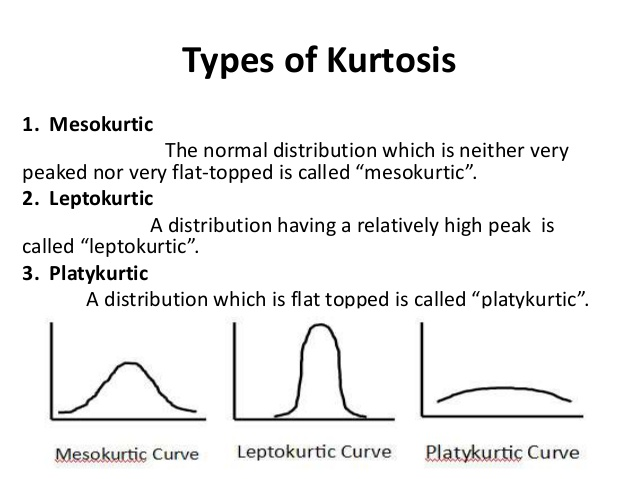

It is very difficult to interpret and analyse the data which is skewed. 

### `Some Transformations for highly skewed data` :

We can perform a number of transformations so that the data information remains preserved while at the same time some symmetric nature starts developing in its distribution. 

* Taking the square root of each data point and plotting it again.
* Taking the cube root of each data point and plotting it again.
* Taking the logarithm of each data point and plotting it again.
* Taking the reciprocal of each data point and plotting it again.

Channel plotting

The range of spread = 185.90


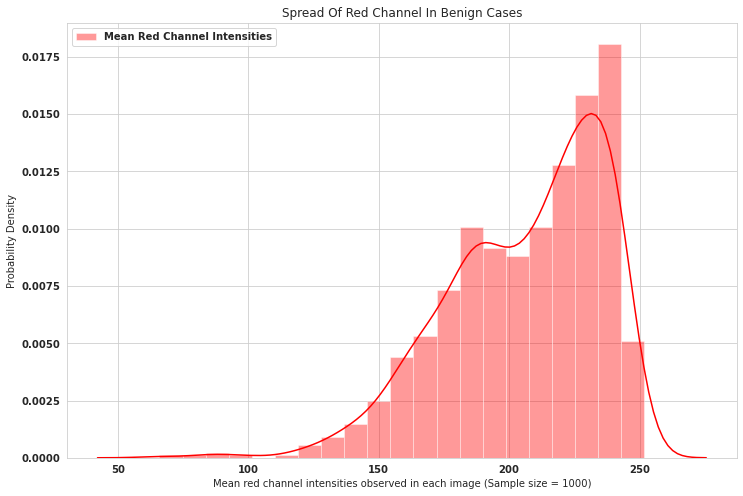

In [21]:
#red channel plot
range_of_spread = max(red) - min(red)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(red, hist = True, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig.set(xlabel = "Mean red channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density")
plt.title("Spread Of Red Channel In Benign Cases")
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

The range of spread = 214.92


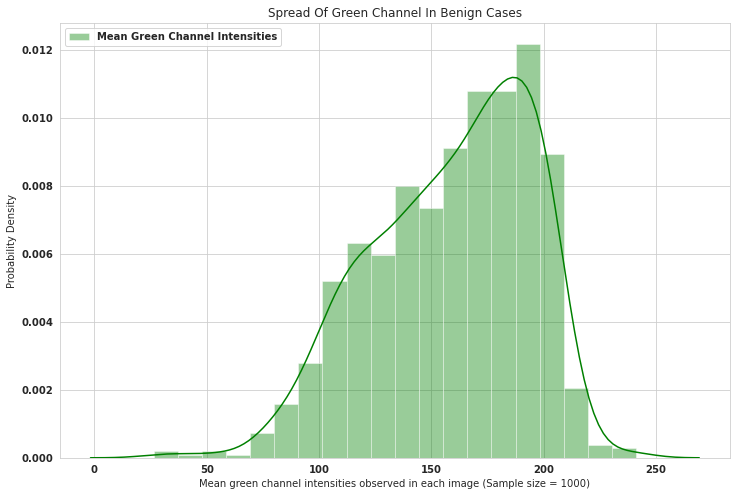

In [22]:
#green channel plot
range_of_spread = max(green) - min(green)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(green, hist = True, kde = True, label = "Mean Green Channel Intensities", color = "g")
fig.set(xlabel = "Mean green channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Green Channel In Benign Cases")
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

The range of spread = 230.89


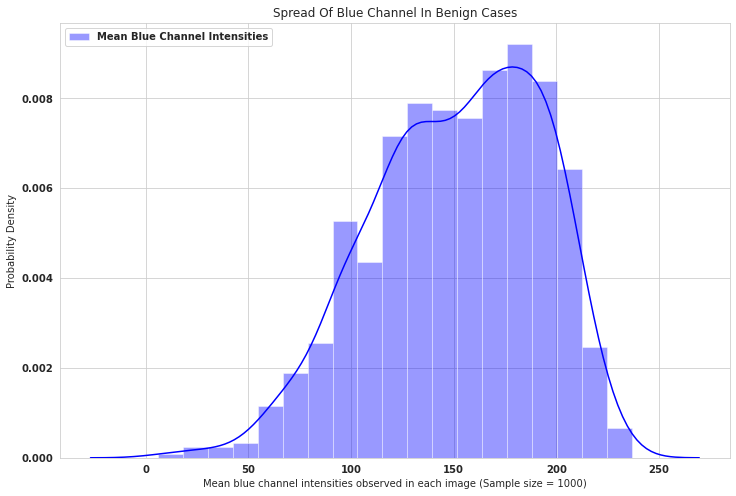

In [23]:
#Blue channel plot
range_of_spread = max(blue) - min(blue)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(blue, hist = True, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig.set(xlabel = "Mean blue channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Blue Channel In Benign Cases")
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

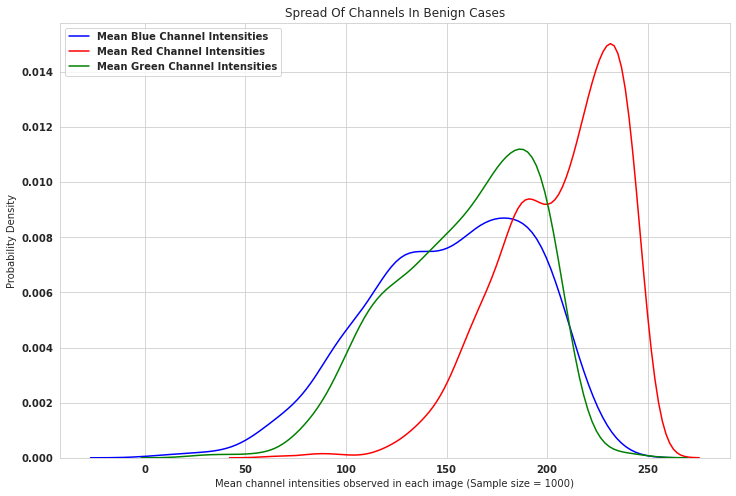

In [24]:
plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(blue, hist = False, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig = sns.distplot(red, hist = False, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig = sns.distplot(green, hist = False, kde = True, label = "Mean Green Channel Intensities", color = "g")

fig.set(xlabel = "Mean channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Channels In Benign Cases")
plt.legend()

Malignant Cases 

In [25]:
# free up the memory
del red
del green
del blue

In [26]:
# Benign Cases
malignant = train[train["target"] == 1] 
image_names = malignant["image_name"].values
image_names = image_names + ".jpg"
benign_image_list = [np.random.choice(image_names) for i in tqdm(range(len(image_names)))]

red = []
green = [] 
blue = []

for image_name in tqdm(benign_image_list) : 
    image = cv2.imread(os.path.join(train_dir, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mean_red = np.mean(image[:,:,0])
    mean_green = np.mean(image[:,:,1])
    mean_blue = np.mean(image[:,:,2])
    
    red.append(mean_red)
    green.append(mean_green)
    blue.append(mean_blue)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


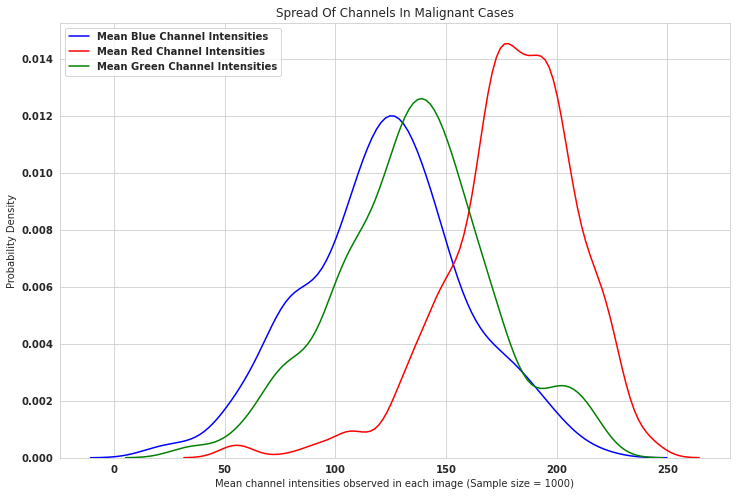

In [27]:
plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(blue, hist = False, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig = sns.distplot(red, hist = False, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig = sns.distplot(green, hist = False, kde = True, label = "Mean Green Channel Intensities", color = "g")

fig.set(xlabel = "Mean channel intensities observed in each image (Sample size = 1000)",
        ylabel = "Probability Density") 
plt.title("Spread Of Channels In Malignant Cases")
plt.legend()

So, we observe that in both the cases the component of red spikes the most, whereas Blue and Green are close to each other. All the channels also appears to be a bit negatively skewed. Hence, the channel distribution won't be a powerful feature to differentiate between the malignant and benign cases.

Kutosis of this distribution is manageable. 

# Dealing with missing values : 

Filling the areas of missing values in the dataframe.

In [28]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Sex feature column

Count of missing data =  65
Count of available data =  33061


Text(0.5, 1.0, "Data On Patient's Sex")

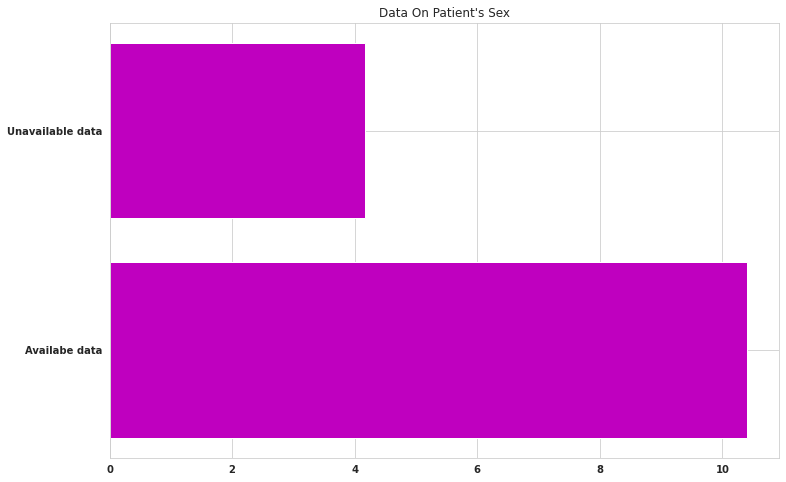

In [29]:
# visualizing missing values in "sex" column

missing = len(train[train["sex"].isna() == True])
available = len(train[train["sex"].isna() == False])

x = ["Availabe data", "Unavailable data"]
y = [np.log(available), np.log(missing)] # plotting log data as the extreme values will supressed and lower ones will shoot, making it eay to visualize

print("Count of missing data = ", missing)
print("Count of available data = ", available)

plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.barh(x, y, color = "m")
plt.grid(True)
plt.title("Data On Patient's Sex")

In the starting part of EDA, we saw that the male gender dominated the gender count slightly. So, we fill the missing values with the dominant gender in the dataset. 

In [30]:
train["sex"].fillna("male", inplace = True)

Age feature column

Missing age values =  68
Available age data =  33058


Text(0.5, 1.0, "Data On Patient's Age")

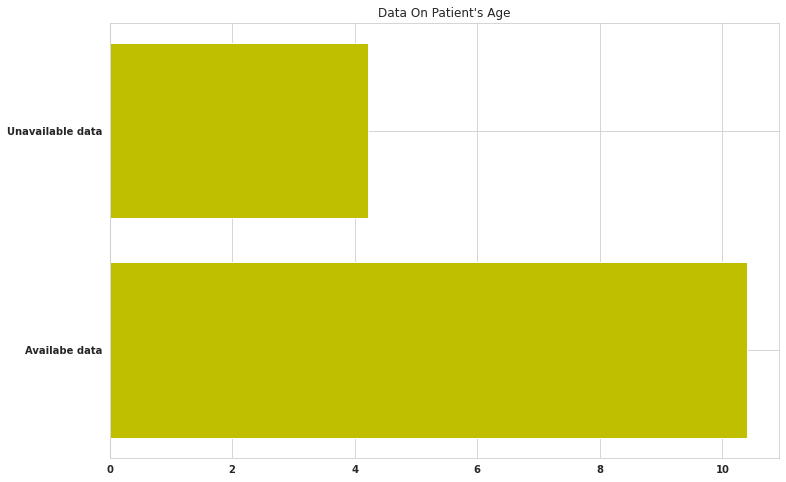

In [31]:
missing =  len(train[train["age_approx"].isna() == True]) 
available = len(train[train["age_approx"].isna() == False]) 

print("Missing age values = ", missing)
print("Available age data = ", available)

x = ["Availabe data", "Unavailable data"]
y = [np.log(available), np.log(missing)] # plotting log data as the extreme values will supressed and lower ones will shoot, making it eay to visualize

plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.barh(x, y, color = "y")
plt.grid(True)
plt.title("Data On Patient's Age")

This is similar to the sex distribution part.

We know so far 

* Males are relatively dominant in count in the dataset
* Torso, lower extremity and upper extremity corresponds to more than 70% of overall locations(initial EDA steps)
* Number of malignant cases are far less than benign, and then also they male count dominates in both. 

Therefore, we fill the missing values with the median data at the union of the aforementioned cases. Let's see how...

In [32]:
anatomy_sites = ["torso", "upper extremity", "lower extremity"]

# first select the relevant part of the full dataframe satisfying either of the aforementioned three conditions.
relevant_dataframe_part = train[(train["sex"] == "male") &
                     (train["anatom_site_general_challenge"].isin(anatomy_sites)) &
                     (train["target"] == 0)]

# Now, we have the data frame. To calculate median, we need to specify the column along which we intend to calculate the median.
median_value = relevant_dataframe_part["age_approx"].median()

print("Median value = ", median_value)

Median value =  50.0


In [33]:
train["age_approx"].fillna(median_value, inplace = True)

Anatomy feature column

We simply replace the missing values(if any) with "TORSO" class, as it is the dominant one here.

In [34]:
train["anatom_site_general_challenge"].fillna("torso", inplace = True)

# Image Pre-Processing

### Image Denoising : 

Many image smoothing techniques like Gaussian Blurring, Median Blurring etc were good to some extent in removing small quantities of noise. In those techniques, we took a small neighbourhood around a pixel and performed some operations like gaussian weighted average, median of the values etc to replace the central element. In short, noise removal at a pixel was local to its neighbourhood. 

There is a property of noise. **Noise is generally considered to be a random variable with zero mean**. 

Suppose we hold a static camera to a certain location for a couple of seconds. This will give us plenty of frames, or a lot of images of the same scene. Then averaging all the frames, we compare the final result and first frame. Reduction in noise would be easily observed. 

So idea is simple, we need a set of similar images to average out the noise. Considering a small window (say 5x5 window) in the image, chance is large that the same patch may be somewhere else in the image. Sometimes in a small neighbourhood around it. Hence, using these similar patches together averaging them can lead to an efficient denoised image. 

This method is **Non-Local Means Denoising**. It takes more time compared to blurring techniques, but the result are very satisfying. 

Denoising illustration : 
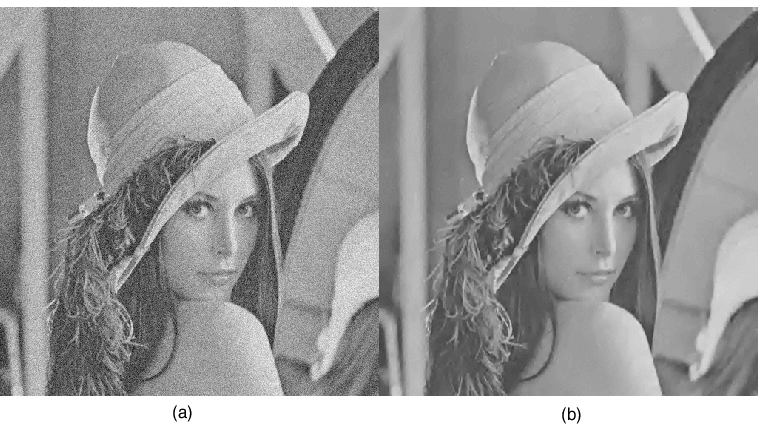

### OpenCV implementation of the aforementioned approach : 

cv2.fastNlMeansDenoisingColored() - Works on Colored images
cv2.fastNlMeansDenoising() - Works on graysacle images

Common arguments are:

* h : parameter deciding filter strength. Higher h value removes noise better, but removes details of image also. (10 is ok)
* hForColorComponents : same as h, but for color images only. (normally same as h)
* templateWindowSize : should be odd. (recommended 7)
* searchWindowSize : should be odd. (recommended 21)

In [35]:
def non_local_means_denoising(image) : 
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

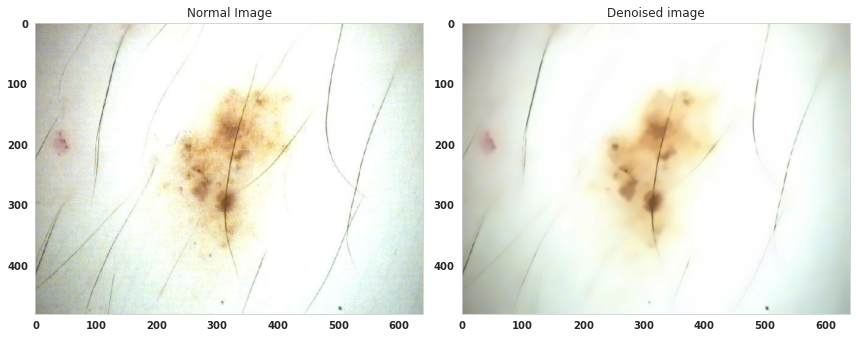

In [36]:
sample_image = cv2.imread(os.path.join(train_dir, random_images[0]))
# cv2 reads images in BGR format. Hence we convert it to RGB
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
denoised_image = non_local_means_denoising(sample_image)


plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image")

plt.subplot(1,2,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised image")    
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()    

### Local Histogram Pre-Processing

#### `First of all, why can't we apply histogram equalization directly to an RGB image?` 

Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is incorrect. Equalization involves intensity values of the image, not the color components. So for a simple RGB color image, histogram equalization cannot be applied directly on the channels. It needs to be applied in such a way that the intensity values are equalized without disturbing the color balance of the image. So, the first step is to convert the color space of the image from RGB into one of the color spaces that separates intensity values from color components. Some of the possible options are HSV/HLS, YUV, YCbCr, etc. YCbCr is preferred as it is designed for digital images. Perform histogram equalization on the intensity plane Y. Now convert the resultant YCbCr image back to RGB.

(Excerpt taken from :

https://prateekvjoshi.com/2013/11/22/histogram-equalization-of-rgb-images/ ) 

An illustration of histogram equalization :

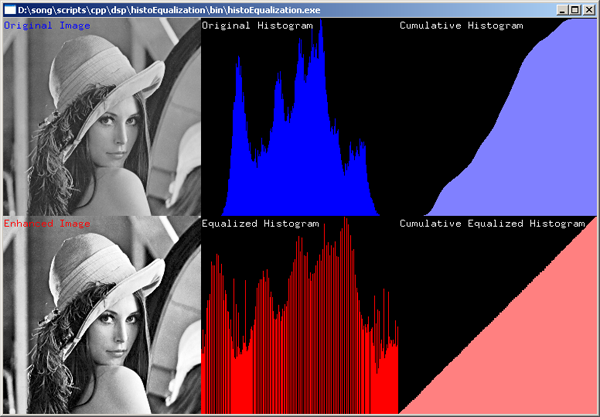


In [37]:
def histogram_equalization(image) : 
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    y_channel = image_ycrcb[:,:,0] # apply local histogram processing on this channel
    cr_channel = image_ycrcb[:,:,1]
    cb_channel = image_ycrcb[:,:,2]
    
    # Local histogram equalization
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8,8))
    equalized = clahe.apply(y_channel)
    equalized_image = cv2.merge([equalized, cr_channel, cb_channel])
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_YCR_CB2RGB)
    return equalized_image

In [38]:
equalized_image = histogram_equalization(denoised_image)

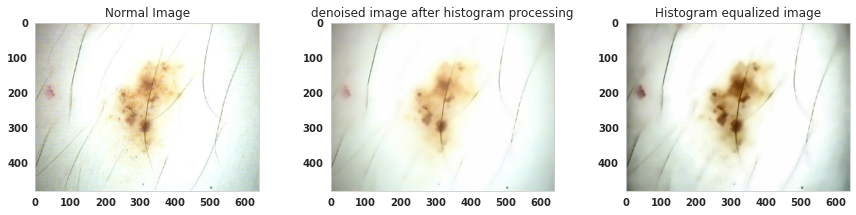

In [39]:
plt.figure(figsize = (12, 8))
plt.subplot(1,3,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image")

plt.subplot(1,3,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("denoised image after histogram processing")

plt.subplot(1,3,3)  
plt.imshow(equalized_image, cmap = "gray")
plt.grid(False)
plt.title("Histogram equalized image")
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

### Image Segmentation : 

Is the technique of dividing or partitioning an image into parts, called segments. It is mostly useful for applications like image compression or object recognition, because for these types of applications, it is inefficient to process the whole image.

We will use **K-means clustering algorithm** to segment the images.

#### `K-Means Segmentation Approach Using OpenCV`

* `samples` : It should be of np.float32 data type, and each feature should be put in a single column. Here we have 3 channels, so every channel features have to be in one column. So, total columns we have are 3, while we don't care about the number of rows, hence -1. So, shape : (-1, 3). 

* `nclusters(K)` : Number of clusters required at end. 

* `criteria` : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are `( type, max_iter, epsilon )`:

Type of termination criteria. It has 3 flags as below:

1. `cv.TERM_CRITERIA_EPS` - stop the algorithm iteration if specified accuracy, epsilon, is reached.
2. `cv.TERM_CRITERIA_MAX_ITER` - stop the algorithm after the specified number of iterations, max_iter.
3. `cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER` - stop the iteration when any of the above condition is met.

*max_iter - An integer specifying maximum number of iterations.
epsilon - Required accuracy *

* `attempts` : Flag to specify the number of times the algorithm is executed using different initial labellings. The algorithm returns the labels that yield the best compactness. This compactness is returned as output.

* `flags` : This flag is used to specify how initial centers are taken. Normally two flags are used for this : cv.KMEANS_PP_CENTERS and cv.KMEANS_RANDOM_CENTERS.

---------------------------------------------------------------

##### Output parameters : 

1. `compactness` : It is the sum of squared distance from each point to their corresponding centers.
2. `labels` : This is the label array (same as 'code' in previous article) where each element marked '0', '1'.....
3. `centers` : This is array of centers of clusters.

In [40]:
def segmentation(image, k, attempts) : 
    vectorized = np.float32(image.reshape((-1, 3)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    res , label , center = cv2.kmeans(vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape((image.shape))
    return segmented_image

Text(0.5, 1.0, 'de Noised Image')

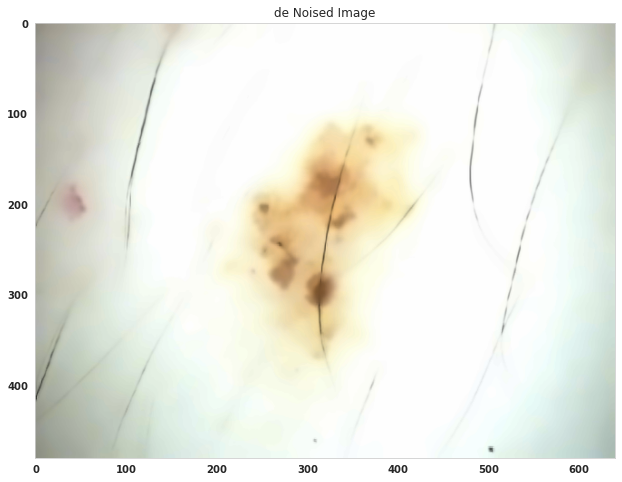

In [41]:
plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("de Noised Image")

Text(0.5, 1.0, 'Segmented Image with k = 5')

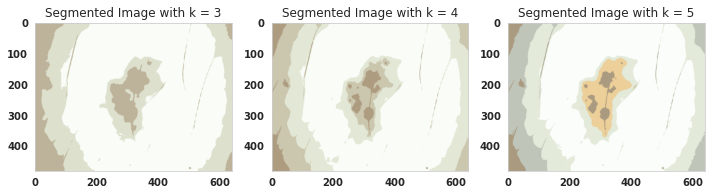

In [42]:
plt.figure(figsize = (12, 8))
segmented_image = segmentation(denoised_image, 3, 10) # k = 3, attempt = 10
plt.subplot(1,3,1)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 3")

segmented_image = segmentation(denoised_image, 4, 10) # k = 4, attempt = 10
plt.subplot(1,3,2)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 4")

segmented_image = segmentation(denoised_image, 5, 10) # k = 5, attempt = 10
plt.subplot(1,3,3)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 5")